## Association subtypes language task

In [5]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [6]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [9]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_18-Jun-2017/';
path_association =  os.path.join(path_root,'associations/');
path_networks =  os.path.join(path_root,'networks/');

In [10]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno = sorted(list_pheno)
list_pheno

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9']

In [11]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['story']

In [12]:
list_subtype = ['sub1','sub2','sub3','sub4','sub5']

In [13]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_root,'{}_r2.csv'.format(trial_name)))

In [14]:
pheno_r2_final

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
sub1,0.031365,0.038060,0.029533,0.046171,0.036431,0.030244,0.030823,0.029535,0.051124
sub2,0.040732,0.029860,0.025771,0.085480,0.039803,0.025138,0.026600,0.027787,0.044652
sub3,0.031662,0.038123,0.031036,0.047346,0.037537,0.031003,0.031731,0.031316,0.053237
sub4,0.024919,0.033241,0.029702,0.029539,0.030472,0.029882,0.028140,0.028319,0.046491
sub5,0.031779,0.040206,0.032998,0.045240,0.038847,0.033831,0.033092,0.032289,0.054352


### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [15]:
%%R
library(ggradar)
library(svglite)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

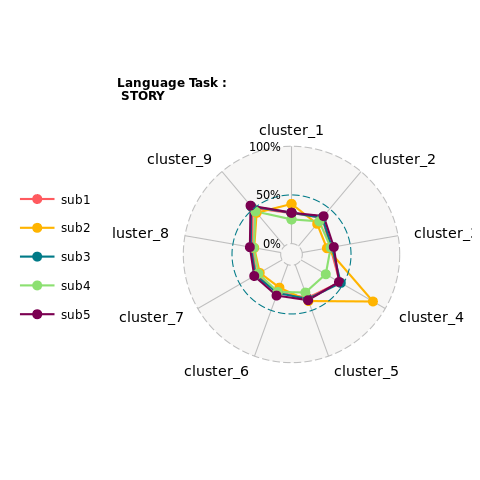

In [16]:
%%R -i path_root,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_root,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_root,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [29]:
# plot association wieght and phenotypes
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_y =mat_load['model_raw']['y']
        model_x = mat_load['model_raw']['x']
        model_labels_x = mat_load['model_raw']['labels_x']
        model_labels_y = mat_load['model_raw']['labels_y']
        concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
        model_df = pd.DataFrame(concat)
        model_df.index = model_labels_x
        colnames = np.concatenate([list_subtype,model_labels_y])
        model_df.columns = colnames
        model_df.to_csv(os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name)))
        
        # plot association maps
        #for subtype in list_subtype:
        #    fig = plt.figure(figsize=(9,16))
        #    ax1 = fig.add_subplot(511)
        #    ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
        #    ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
        #    ax1.set_xlabel(pheno_name)

In [33]:
model_df.columns

Index(['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'FD_RL', 'FD_scrubbed_RL',
       'FD_LR', 'FD_scrubbed_LR', 'FD_scrubbed_mean', 'FD_mean', 'Age_in_Yrs',
       'Gender', 'Handedness', 'Mother_ID', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8', 'cluster_9'],
      dtype='object')

In [35]:
model_df.reset_index(level=0)

,index,sub1,sub2,sub3,sub4,sub5,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,...,Mother_ID,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,HCP100206,-0.044002,0.133014,0.038918,-0.088635,0.034384,0.088456,0.088456,0.099963,0.099963,...,56037.0,-1.143794,1.304835,1.285918,-0.034336,0.205086,0.053396,0.090798,-0.512524,-0.118881
1,HCP100307,0.577479,0.126689,-0.546649,0.399775,-0.528503,0.101970,0.101970,0.119331,0.119331,...,51488.0,-0.528411,0.493464,0.523816,-0.600763,0.386336,-0.953060,-0.958070,-0.143309,-0.722473
2,HCP100408,-0.206460,-0.082492,0.251270,-0.258280,0.240340,0.128052,0.128052,0.140232,0.140232,...,51730.0,-0.236296,0.020266,0.092588,0.114286,-0.084017,-0.522003,0.619392,0.219196,1.037169
3,HCP100610,0.272108,0.075579,-0.308281,0.324437,-0.321563,0.189474,0.189474,0.179002,0.179002,...,52813.0,2.022214,0.895451,-0.361691,1.234488,0.709151,-0.882736,-0.323026,-0.199254,0.459399
4,HCP101006,-0.068098,-0.102695,0.045742,0.002438,0.086594,0.156877,0.156877,0.131924,0.131924,...,51283.0,0.591952,-1.191472,0.037988,-0.682910,-0.516141,0.056823,-0.275139,-0.310782,0.308365
5,HCP101107,-0.579395,-0.447603,0.646160,-0.361884,0.484283,0.224189,0.131822,0.325583,0.119171,...,51969.0,-0.236587,-0.055247,0.202737,0.108271,-0.816365,0.164527,1.259271,0.350204,0.123138
6,HCP101309,-0.365247,-0.317822,0.320177,-0.055755,0.284151,0.074865,0.074865,0.089064,0.089064,...,52385.0,2.460648,-0.639590,-1.056096,-0.458966,-0.579394,-0.306816,-0.491635,0.396082,-0.336725
7,HCP101410,-0.456847,-0.161918,0.520390,-0.473627,0.473163,0.126619,0.126619,0.133569,0.133569,...,52198.0,-0.737608,-0.286803,-0.213357,0.012024,-0.830777,-0.408648,0.020646,0.388261,0.779067
8,HCP101915,0.041047,0.243031,-0.072019,-0.038360,-0.028678,0.093385,0.093385,0.097605,0.097605,...,51977.0,1.461551,-1.096840,-0.838275,1.016038,0.083408,-0.056452,0.159738,1.173397,-0.532920
9,HCP102008,-0.061059,0.213092,-0.005173,-0.033090,0.035772,0.162509,0.162362,0.171901,0.169665,...,52018.0,-0.891228,0.787911,-0.101854,0.511281,0.198667,0.152497,-0.006320,0.653874,0.721998


In [20]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # read csv and manip tables 
import scipy.io #read .mat files

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [23]:
 # import all pheno data
all_pheno = pd.read_csv(os.path.join('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv'))

In [ ]:
all_data_X = pd.merge(model_df[['cluster_1','cluster_2','cluster_3','cluster_4','cluster_5',
               'cluster_6','cluster_7','cluster_8','cluster_9']])

In [2]:
y = model_df['cluster_4'].values
x = model_df['sub2'].values.reshape(-1,1)
print('y shape:',y.shape)
print('x shape:',x.shape)

NameError: name 'model_df' is not defined

In [3]:
y = model_df['sub2'].values
x_= model_df[['cluster_1','cluster_2','cluster_3','cluster_4','cluster_5',
               'cluster_6','cluster_7','cluster_8','cluster_9']]
x =x_.values
print('y shape:',y.shape)
print('x shape:',x.shape)

NameError: name 'model_df' is not defined

In [59]:

feimp_l = np.zeros((5,x.shape[1]))

rfr = RandomForestRegressor(n_estimators=1000,oob_score=True,n_jobs=-1)
skf = KFold(n_splits=5)
feimp_l = np.zeros((skf.n_splits,x.shape[1]))
scores = np.zeros((skf.n_splits,1))
c = 0
for train_index, test_index in skf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfr.fit(x_train, y_train)
    pred = rfr.predict(x_test)
    rsq = rfr.score(x_test, y_test)
    #print(rsq)
    
    feimp = rfr.feature_importances_
    feimp_l[c,:] = feimp[:]
    scores[c,:] = rsq
    c+=1
    

In [61]:
mean_feimp = np.mean(feimp_l, axis=0)

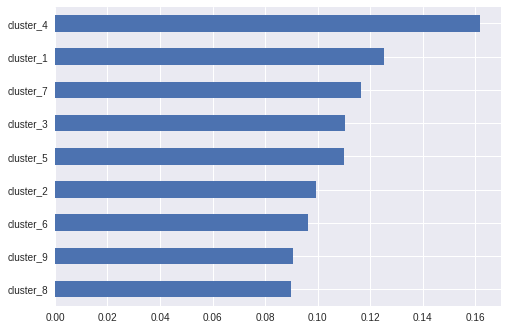

In [66]:
feature_importances = pd.Series(mean_feimp,index= x_.columns)
feature_importances.sort()
feature_importances.plot(kind='barh')

In [63]:
model_df[['cluster_1','cluster_2','cluster_3','cluster_4','cluster_5',
               'cluster_6','cluster_7','cluster_8','cluster_9']].columns

Index(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'],
      dtype='object')

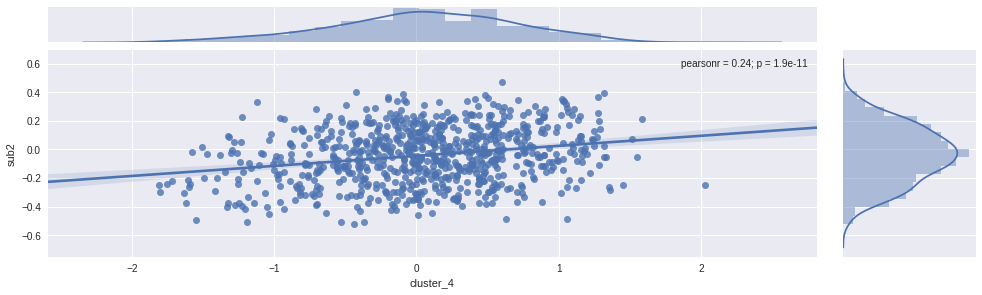

In [133]:
grid = sns.jointplot( y="sub2", x="cluster_4", data=model_df,kind='reg');
grid.fig.set_figwidth(15)
grid.fig.set_figheight(4)

In [158]:
X


array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  6.07600000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   5.64000000e+00],
       [  1.09590000e-01,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.93450000e+02,   6.48000000e+00],
       [  4.74100000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   7.88000000e+00]])

In [142]:
from sklearn.datasets import  load_boston
data = load_boston()
X = data.data
Y = data.targetX

In [147]:
X.shape,Y.shape

((506, 13), (506,))

In [152]:
X[:,1]

array([  18. ,    0. ,    0. ,    0. ,    0. ,    0. ,   12.5,   12.5,
         12.5,   12.5,   12.5,   12.5,   12.5,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,   75. ,
         75. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,   21. ,   21. ,   21. ,   21. ,   75. ,   90. ,
         85. ,  100. ,   25. ,   25. ,   25. ,   25. ,   25. ,   25. ,
         17.5,   80. ,   80. ,   12.5,   12.5,   12.5,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
         25. ,   25. ,   25. ,   25. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,   28. ,   28. ,   28. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
      

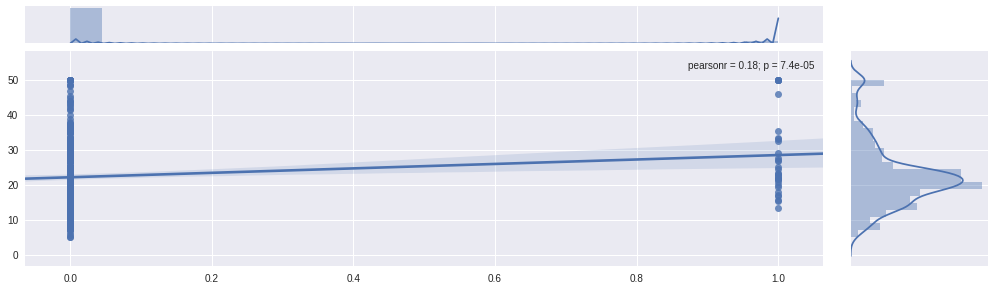

In [155]:
grid = sns.jointplot( y=Y, x=X[:,3],kind='reg');
grid.fig.set_figwidth(15)
grid.fig.set_figheight(4)

In [76]:
scl = preprocessing.StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))[:,0]
#x = scl.fit_transform(x)

In [126]:
# init CV
scores = []
skf = KFold(n_splits=3)
for train_index, test_index in skf.split(x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train model
    clf = SVR(kernel='linear', C=1e3)
    #clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
    
    # grid search cv
    #clf = GridSearchCV(clf, cv=10,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)},n_jobs=6)

    clf.fit(x_train, y_train)
    #sv_ratio = clf.best_estimator_.support_.shape[0] / (1.*len(y_train))
    #print("Support vector ratio: %.3f" % sv_ratio)
    
    # test
    scores.append(clf.score(x_test,y_test))
    #print(scl.inverse_transform(clf.predict(x_test)))
    print(scores[-1])
    
print('Average R2: ', np.mean(scores))


0.0643228755385
0.038372600127
0.0508334175103
Average R2:  0.0511762977253


In [156]:
# train model
#clf = SVR(kernel='rbf', C=1.0, epsilon=0.2, gamma=.0001)
clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
log = LinearRegression()
# grid search cv
#clf = GridSearchCV(clf, cv=10,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)},n_jobs=6)
log.fit(x,y)
clf.fit(x,y)

ValueError: Found input variables with inconsistent numbers of samples: [782, 506]

In [131]:
predSvr = clf.predict(x_test)
predLog = log.predict(x_test)

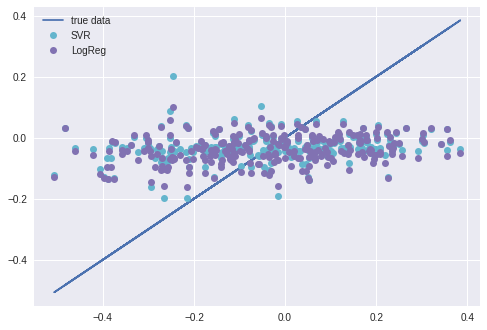

In [132]:
plt.plot(y_test, y_test, label='true data')
plt.plot(y_test, predSvr, 'co', label='SVR')
plt.plot(y_test, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()

In [71]:
plt.plot(testY, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()

NameError: name 'testY' is not defined

In [50]:
clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
r = clf.fit(b, y_train)

In [53]:
print(r)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [47]:
b = np.concatenate((np.ones(x_train.shape + (1,)), x_train[..., None]),1)

In [54]:
b

array([[ 1.        , -0.30849142],
       [ 1.        , -0.02320696],
       [ 1.        ,  0.08609446],
       ..., 
       [ 1.        ,  0.0869828 ],
       [ 1.        , -0.06180076],
       [ 1.        ,  0.03654179]])

In [48]:
b.shape

(521, 2)

In [35]:
x_train.shape

(521,)

In [36]:
y_train.shape

(521,)

In [43]:
y_train

array([  7.19714152e-01,  -6.16568569e-01,   7.51768143e-01,
        -2.56341148e-01,  -2.08548321e-01,   1.65869777e+00,
        -1.07640005e+00,  -7.56461032e-01,   1.39542587e+00,
        -1.22367986e+00,   2.70661413e+00,   1.62839525e+00,
        -1.33460468e+00,  -6.48535360e-01,  -3.56882679e-01,
        -3.44448382e-01,  -7.45097222e-01,   1.42174704e+00,
        -2.22163437e-01,  -9.20499026e-01,  -1.24371487e-01,
         1.16767668e+00,   1.06133380e+00,  -1.02564102e+00,
        -1.18123405e+00,  -4.89680258e-01,   2.24736959e-01,
        -8.24886981e-01,   1.15202306e+00,  -5.01649091e-01,
        -1.55980532e+00,  -9.39876426e-03,  -1.13018284e+00,
        -7.59630933e-01,   1.67678220e+00,  -9.78152128e-01,
         1.64552427e+00,   4.88957728e-02,  -5.34707072e-01,
         1.05340894e+00,  -1.29770426e+00,  -1.43982040e+00,
        -1.38773599e+00,   7.50200078e-01,  -3.53643982e-01,
         1.19984200e+00,   2.91774550e+00,  -2.99774797e-01,
         7.62898879e-01,

In [42]:
x_train

array([-0.30849142, -0.02320696,  0.08609446,  0.18430688, -0.21208545,
       -0.58278535,  0.00305323, -0.77162255, -0.45663901,  0.05136636,
        0.22729541, -0.16015158, -0.68875003, -0.43226511,  0.05376947,
        0.22713237, -0.88893138, -0.37382915, -0.02761577, -0.4243101 ,
        0.26484978, -0.54914459, -0.12306755,  0.45521993,  0.15100539,
       -0.20144924, -0.17204038, -0.10768164, -0.15872905, -0.33746947,
       -0.47054225,  0.08342435,  0.23408141,  0.13521806,  0.17529201,
       -0.11546233,  0.12689403,  0.10487231,  0.24965284, -0.86906494,
       -0.59365779,  0.03719171,  0.39182195, -0.0533519 ,  0.3295965 ,
        0.12125083, -0.15920628,  0.08991829, -0.13515812,  0.02440385,
        0.21928849,  0.01790158,  0.06929018,  0.15320444, -0.08628468,
        0.20753865, -0.02964557,  0.04064956, -0.2006894 ,  0.33961272,
        0.08358905, -0.38963218, -0.1998677 , -0.02621379, -0.18704808,
       -0.22423859,  0.51361047, -0.46549336,  0.00626338, -0.83

In [37]:
type(y_train)

numpy.ndarray

In [38]:
type(x_train)

numpy.ndarray

In [40]:
np.sum(np.isnan(y_train))

0